In [1]:
import cv2 
import os
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt
from matplotlib import gridspec
import math
import numpy.matlib
import warnings
warnings.filterwarnings("ignore")
import time

## Recovering HDR image based on Debevec algorithm 

In [53]:
class HDRImaging:
    def __init__(self,path):
        filenames = ["img0.jpg", "img1.jpg", "img2.jpg", "img3.jpg"]
        self.images = [cv2.imread(''.join(path+fn)) for fn in filenames]
        self.times = np.array([1/30.0, 0.25, 2.5, 15.0], dtype=np.float32)
        self.N = len(self.images)
        self.row = len(self.images[0])
        self.col = len(self.images[0][0])
        
        # Align input images
        alignMTB = cv2.createAlignMTB()
        alignMTB.process(self.images, self.images)
        
        # weighting factor for smoothness of response curves 
        self.l = 10 
          
    def display_OriginalImages(self,figureSize):
        offset = 50    
        Canvas = np.ones((self.row, (self.col+offset)*self.N,3),dtype=np.float32)
               
        for l in range(self.N):
            c1 = l*(self.col+offset)
            c2 = c1 + self.col 
            Canvas[0:self.row, c1:c2,:] = (self.images[l]/255).astype(np.float32)
 
        fig = plt.figure(constrained_layout=False,figsize=figureSize)
        plt.imshow(cv2.cvtColor(Canvas[:,:c2,:],cv2.COLOR_BGR2RGB))
        plt.title("underexposed  <---    Original images    --->   overexposed", fontsize=20)
        plt.xticks([])
        plt.yticks([])
        
    def constructWeightingFunction(self):
        # construct a weighting function 
        Zmin = 0 
        Zmax = 255 
        Zmid = (Zmax+Zmin)//2

        self.w = np.zeros((Zmax-Zmin+1))

        for z in range(Zmin,Zmax+1): 
            if z <= Zmid:
                self.w[z] = z - Zmin + 1
            else: 
                self.w[z] = Zmax - z + 1
            
        
    def samplingPixelValues(self):
    
        numSamples = math.ceil(255*2/(self.N-1))*2
        numPixels = self.row * self.col
        
        step = int(np.floor(numPixels/numSamples))
        self.sampleIndices = list(range(0,numPixels,step))[:-1] 
        
        # get flatten image 
        self.flattenImage = np.zeros((self.N, 3, numPixels),dtype=np.uint8)
        for i in range(self.N):
            for c in range(3):
                self.flattenImage[i,c] = np.reshape(self.images[i][:,:,c], (numPixels,))
        
        X = np.log(self.times)
        
        # set arrays to store pixel values at sampled locations 
        self.ZG = np.zeros((numSamples,self.N) ,dtype=np.uint8)
        self.ZB = np.zeros((numSamples,self.N,),dtype=np.uint8)
        self.ZR = np.zeros((numSamples,self.N) ,dtype=np.uint8)
    
    
        # get the sampled pixel values 
        for k in range(self.N):            
            self.ZB[:,k] = self.flattenImage[k,0][self.sampleIndices]
            self.ZG[:,k] = self.flattenImage[k,1][self.sampleIndices]
            self.ZR[:,k] = self.flattenImage[k,2][self.sampleIndices]
        
        
        ind = np.arange(0,numSamples)                                                
        idx = []
        for i in range(numSamples):
            for k in range(self.N-1): 
                if self.ZG[i,k] > self.ZG[i,k+1]:
                    idx.append(i)
                    break
        ind=np.delete(ind,idx,0)
        self.ZB = self.ZB[ind]
        self.ZG = self.ZG[ind]
        self.ZR = self.ZR[ind]        
        
        # set arrays to store log exposure times 
        r,c = self.ZG.shape[:2]
        self.Bij = np.matlib.repmat(np.log(self.times), r*c,1)
    

    def gsolve(self,Z):
        # this function is a python version of the one provided by Debevec's paper. 
        '''        
        solve for imaging system response function 

        Given a set of pixel values observed for several pixels 
        in several images with different exposure times, 

        this funcction returns the imaging system's response function g as well as the log film irradiance values 
        for the observed pixels 


        Inputs: 
        Z(i,j) : pixel values of pixel locations number i in image j 
        B(j)   : the log delta t for image j
        l   : lambda, the constant that determines the amount of smoothness
        w(z): the weighting function value for pixel value z 

        outputs:
        g(z) : log exposure corresponding to pixel value z 
        lE(i): the log film irradiance at pixel location i 
        '''

        n = 256

        s1, s2 = Z.shape
        A = np.zeros((s1*s2+n+1, n+s1))
        b = np.zeros((A.shape[0],1))

        ## include the data-fitting equations 
        k=0
        for i in range(s1):
            for j in range(s2):
                wij = self.w[Z[i,j]]
                A[k,Z[i,j]] = wij
                A[k,n+i] = -wij
                b[k] = wij*self.Bij[i,j]
                k +=1

        # fix the curve by setting its middle value to zero     
        A[k,129] = 0
        k +=1
    
        # include the smoothness equations 
        for i in range(1,n-2):
            A[k,i] = self.l*self.w[i+1]
            A[k,i+1] = -2*self.l*self.w[i+1]
            A[k,i+2] = self.l*self.w[i+1]
            k +=1
        
        # solve the system using Singular Value Decomposition(SVD)
        x = np.linalg.lstsq(A,b) 
        x = x[0]
        g = x[0:n]
        lE = x[n: len(x)]    
        
        return g,lE
        
    def plot_ResponseCurves(self):    
        px = list(range(0,256))
        plt.figure(constrained_layout=False,figsize=(5,5))
        plt.title("Response curves for BGR", fontsize=20)
        plt.plot(px,np.exp(self.gR),'r')
        plt.plot(px,np.exp(self.gB),'b')
        plt.plot(px,np.exp(self.gG),'g')
        plt.ylabel("log Exposure X", fontsize=20)
        plt.xlabel("Pixel value Z", fontsize=20)
        
    def process(self):
        self.constructWeightingFunction()
        self.samplingPixelValues()
        
        self.gR, self.lER = self.gsolve(self.ZR)
        self.gG, self.lEG = self.gsolve(self.ZG)
        self.gB, self.lEB = self.gsolve(self.ZB)
    

class PostProcess(HDRImaging):
    def __init__(self,HDRImaging):
        super().__init__(path)

    def recover_HDR_RadianceMap(self):
        m = np.zeros((self.flattenImage.shape[1:]))
        wsum = np.zeros(self.flattenImage.shape[1:])
        hdr = np.zeros(self.flattenImage.shape[1:])
        
        lnDt = np.log(self.times)

        for i in range(self.N):

            wij_B = self.w[self.flattenImage[i,0]]
            wij_G = self.w[self.flattenImage[i,1]]
            wij_R = self.w[self.flattenImage[i,2]]
            
            wsum[0,:] += wij_B
            wsum[1,:] += wij_G
            wsum[2,:] += wij_R
            
            m0 = np.subtract(self.gB[self.flattenImage[i,0]],lnDt[i])[:,0]
            m1 = np.subtract(self.gG[self.flattenImage[i,1]],lnDt[i])[:,0]
            m2 = np.subtract(self.gR[self.flattenImage[i,2]],lnDt[i])[:,0]
    
            hdr[0] = hdr[0] + np.multiply(m0,wij_B)
            hdr[1] = hdr[1] + np.multiply(m1,wij_G)
            hdr[2] = hdr[2] + np.multiply(m2,wij_R)

        hdr = np.divide(hdr,wsum)
        hdr = np.exp(hdr)
        hdr = np.reshape(np.transpose(hdr), (self.row,self.col,3))
                    
        self.imgf32 = (hdr/np.amax(hdr)*255).astype(np.float32)
        plt.figure(constrained_layout=False,figsize=(10,10))
        plt.title("fused HDR radiance map", fontsize=20)
        plt.imshow(cv2.cvtColor(self.imgf32,cv2.COLOR_BGR2RGB))        

        

    def tone_mapping(self):
        # Tonemap using Drago's method to obtain 24-bit color image
        tonemapDrago = cv2.createTonemapDrago(1.0, 0.7)
        ldrDrago = tonemapDrago.process(self.imgf32)
        ldrDrago = 3 * ldrDrago
        cv2.imwrite("ldr-Drago-2.jpg", ldrDrago * 255)
        fig = plt.figure(constrained_layout=False,figsize=(10,10))
        plt.title("Tone-mapped image", fontsize=20)
        plt.imshow(cv2.cvtColor(ldrDrago, cv2.COLOR_BGR2RGB))
        

In [54]:
path = "/Users/gimoonnam/myGit/notRepos/ImageProcessing/images/SaintLouisTower/"
mergeDebevec = HDRImaging(path)

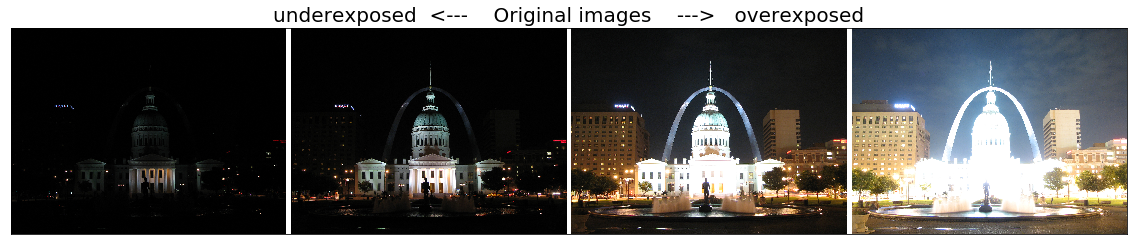

In [55]:
mergeDebevec.display_OriginalImages(figureSize=(20,20))

0.9747059345245361


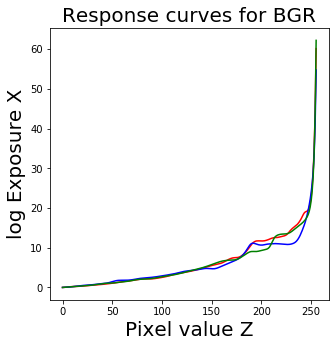

In [56]:
start_time = time.time()
postProcess = PostProcess(mergeDebevec)
postProcess.process()
postProcess.plot_ResponseCurves()
print(time.time() - start_time)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1.8314871788024902


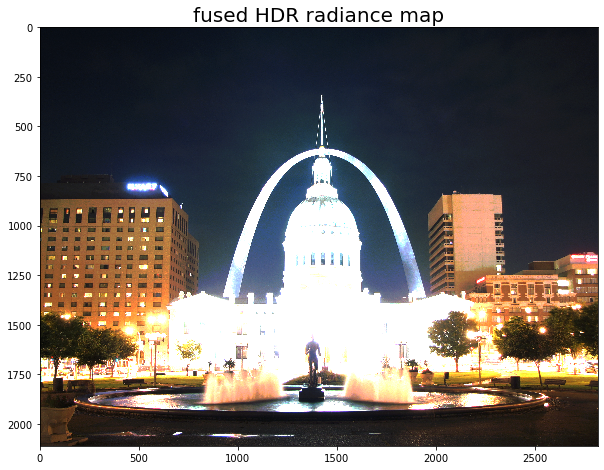

In [58]:
start_time = time.time()
postProcess.recover_HDR_RadianceMap()
print(time.time() - start_time)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


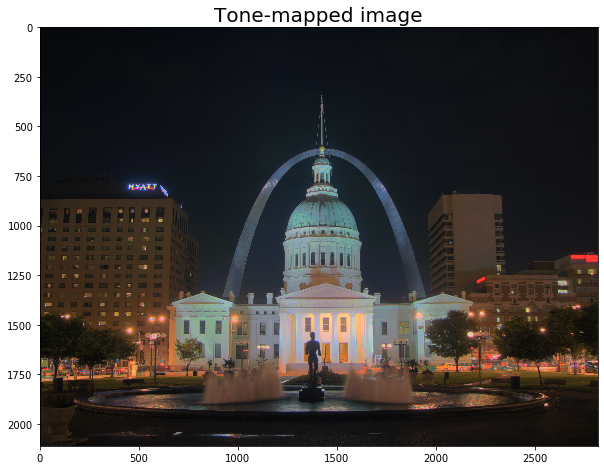

In [60]:
postProcess.tone_mapping()